# Implementation based on the ACGAN paper :
https://arxiv.org/pdf/1511.06434.pdf

# Imports

In [ ]:
from PIL import Image
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import Multiply, LeakyReLU, UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
import wandb
np.random.seed(1337)
wandb.init(project="ACGAN-Digit-Generation")

KERAS_MODEL_FILEPATH = "./model/acgan_mnist_digits.h5"

# Generator

In [6]:
def build_generator(latent_size):
    cnn = Sequential()
    cnn.add(Dense(1024, input_dim=latent_size, activation='relu'))
    cnn.add(Dense(128 * 7 * 7, activation='relu'))
    cnn.add(Reshape((7, 7, 128)))
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Conv2D(256, 5, padding='same', activation='relu',
                   kernel_initializer='glorot_normal'))
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Conv2D(128, 5, padding='same', activation='relu',
                   kernel_initializer='glorot_normal'))
    cnn.add(Conv2D(1, 2, padding='same', activation='tanh',
                   kernel_initializer='glorot_normal'))
    latent = Input(shape=(latent_size,))
    image_class = Input(shape=(1,), dtype='int32')
    # 10 classes in MNIST
    emb = Embedding(10, latent_size, embeddings_initializer='glorot_normal')(image_class)
    cls = Flatten()(emb)
    h = Multiply()([latent, cls])
    fake_image = cnn(h)
    return Model([latent, image_class], fake_image)

# Discriminator

In [7]:
def build_discriminator():
    cnn = Sequential()
    cnn.add(Conv2D(32, 3, padding='same', strides=2, input_shape=(28, 28, 1)))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))
    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))
    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))
    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))
    cnn.add(Flatten())
    image = Input(shape=(28, 28, 1))
    features = cnn(image)
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(10, activation='softmax', name='auxiliary')(features)
    return Model(image, [fake, aux])

# Hyperparameters

In [9]:
epochs = 50
batch_size = 256
latent_size = 100
adam_lr = 0.00005
adam_beta_1 = 0.5

config = dict(
        epochs = 50,
        batch_size = 100,
        latent_size = 100,
        adam_lr = 0.00005,
        adam_beta_1 = 0.5,
)
wandb.config = config

# build the discriminator
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

# build the generator
generator = build_generator(latent_size)
generator.compile(
    optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
    loss='binary_crossentropy'
)

In [10]:
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       1000        ['input_6[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 100)          0           ['embedding_1[0][0]']            
                                                                                            

In [11]:
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 12544)        387840      ['input_4[0][0]']                
                                                                                                  
 generation (Dense)             (None, 1)            12545       ['sequential_2[0][0]']           
                                                                                                  
 auxiliary (Dense)              (None, 10)           125450      ['sequential_2[0][0]']           
                                                                                            

In [12]:
# Visualuzing Keras model architecture
import tensorflow as tf
def draw_model_architecture(model, file_name = "model.png"):
    model_img_file = file_name
    return tf.keras.utils.plot_model(model, to_file=model_img_file, 
                            show_shapes=True, 
                            show_layer_activations=True, 
                            show_dtype=True,
                            show_layer_names=True)

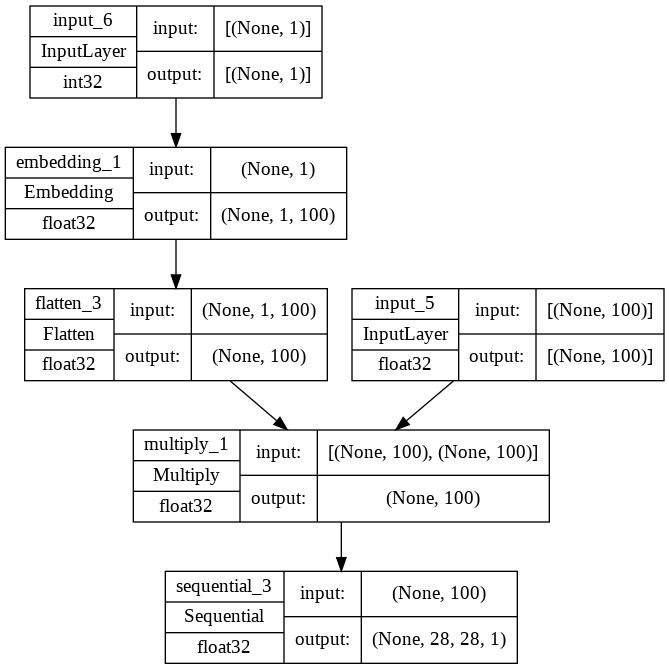

In [13]:
draw_model_architecture(generator, "generator.png")

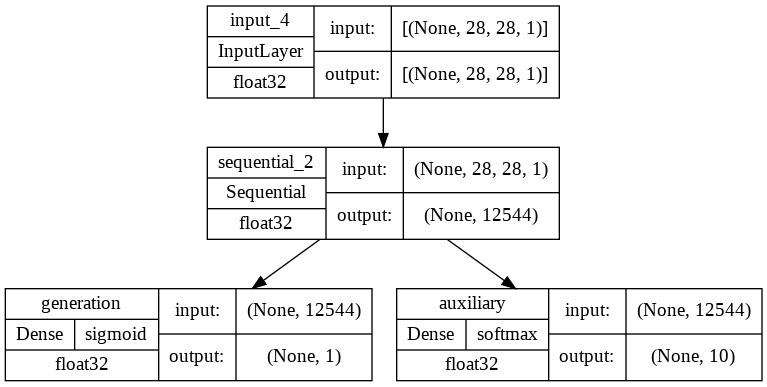

In [14]:
draw_model_architecture(discriminator, "discriminator.png")

# Data

In [15]:
# mnist data, and force it to be of shape (..., 28, 28, 1) with
# range [-1, 1]
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=3)
num_train, num_test = X_train.shape[0], X_test.shape[0]

11490434/11490434 [==============================] - 0s 0us/step


# Composite Model

In [16]:
latent = Input(shape=(latent_size, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model([latent, image_class], [fake, aux])

combined.compile(
    optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

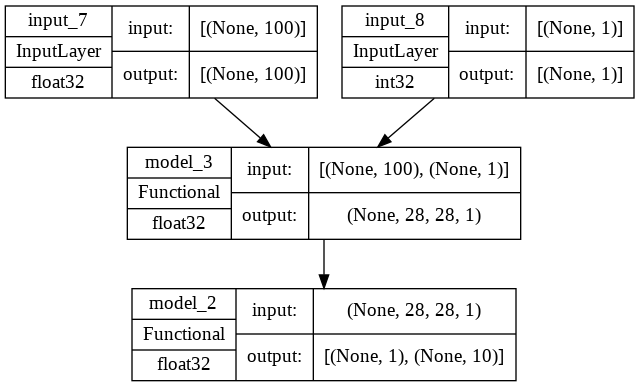

In [17]:
draw_model_architecture(combined, "ACGAN.png")

# Training

In [18]:
print('Epoch\tL_s(G)\tL_s(G)\tL_s(D)\tL_s(D)\tL_c(G)\tL_c(G)\tL_c(D)\tL_c(D)')
from tqdm import tqdm
for epoch in tqdm(range(epochs)):
    print(epoch + 1, end='\t', flush=True)

    num_batches = int(X_train.shape[0] / batch_size)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(num_batches):
        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (batch_size, latent_size))

        # get a batch of real images
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, 10, batch_size)

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (batch_size, 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

        X = np.concatenate((image_batch, generated_images))
        y = np.array([1] * batch_size + [0] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(X, [y, aux_y]))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
        sampled_labels = np.random.randint(0, 10, 2 * batch_size)

        # we want to train the generator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * batch_size)

        epoch_gen_loss.append(
            combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))],
                [trick, sampled_labels]
            )
        )

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (num_test, latent_size))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, 10, num_test)
    generated_images = generator.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=0)

    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * num_test + [0] * num_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(X, [y, aux_y], verbose=0)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
    sampled_labels = np.random.randint(0, 10, 2 * num_test)

    trick = np.ones(2 * num_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels],
        verbose=0
    )

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
    
    print('{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}'.format(
        # generation loss
        generator_train_loss[1], generator_test_loss[1],
        discriminator_train_loss[1], discriminator_test_loss[1],
        # auxillary loss
        generator_train_loss[2], generator_test_loss[2],
        discriminator_train_loss[2], discriminator_test_loss[2],
    ))

    wandb.log({"generator_train_loss":generator_train_loss[1]})
    wandb.log({"generator_test_loss":generator_test_loss[1]})
    wandb.log({"discriminator_train_loss":discriminator_train_loss[2]})
    wandb.log({"discriminator_test_loss":discriminator_test_loss[2]})

    # save model every epoch
    generator.save(KERAS_MODEL_FILEPATH)

    # generate some digits to display
    noise = np.random.uniform(-1, 1, (100, latent_size))

    sampled_labels = np.array([[i] * 10 for i in range(10)]).reshape(-1, 1)

    # get a batch to display
    generated_images = generator.predict([noise, sampled_labels], verbose=0)

    # arrange them into a grid
    img = (np.concatenate([r.reshape(-1, 28)
                           for r in np.split(generated_images, 10)
                           ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

    Image.fromarray(img).save('./generated_digits_plots/mnist_acgan_generated_{0:03d}.png'.format(epoch))
    
print('Training is finished.')

Epoch	L_s(G)	L_s(G)	L_s(D)	L_s(D)	L_c(G)	L_c(G)	L_c(D)	L_c(D)


  0%|          | 0/50 [00:00<?, ?it/s]

1	1.2390	0.8353	0.5568	0.6581	2.3598	2.4074	1.8961	1.5821


  2%|▏         | 1/50 [01:40<1:22:25, 100.93s/it]

2	

  4%|▍         | 2/50 [03:05<1:13:15, 91.57s/it] 

0.9328	1.1441	0.6580	0.4613	1.5835	0.4288	1.1324	0.4250
3	

  6%|▌         | 3/50 [04:32<1:09:48, 89.12s/it]

1.0887	1.2835	0.6505	0.3791	0.4058	0.2051	0.4855	0.3555
4	

  8%|▊         | 4/50 [05:58<1:07:26, 87.96s/it]

1.1282	1.0270	0.6139	0.5300	0.2384	0.1827	0.3859	0.3070
5	

 10%|█         | 5/50 [07:22<1:05:03, 86.74s/it]

1.0645	1.0749	0.6363	0.5068	0.1741	0.0914	0.3325	0.2353
6	

 12%|█▏        | 6/50 [08:48<1:03:23, 86.45s/it]

0.9233	0.9601	0.6924	0.6492	0.1049	0.1225	0.2669	0.2283
7	

 14%|█▍        | 7/50 [10:12<1:01:23, 85.66s/it]

1.0220	0.9662	0.6279	0.5090	0.1070	0.0440	0.2575	0.1754
8	

 16%|█▌        | 8/50 [11:38<59:57, 85.66s/it]  

1.0678	1.3399	0.5986	0.4210	0.0887	2.3846	0.2333	1.3656
9	

 18%|█▊        | 9/50 [13:04<58:31, 85.66s/it]

1.2000	0.9043	0.5697	0.6714	0.1264	0.0636	0.2575	0.2143
10	1.1653	0.7824	0.5977	0.6366	0.1193	0.0467	0.2500	0.1545


 20%|██        | 10/50 [14:29<57:03, 85.60s/it]

11	

 22%|██▏       | 11/50 [15:56<55:52, 85.96s/it]

1.1413	1.4481	0.5650	0.3833	0.0689	0.0354	0.1981	0.1483
12	

 24%|██▍       | 12/50 [17:22<54:23, 85.88s/it]

1.2623	0.7531	0.5278	0.7494	0.0677	0.0826	0.1878	0.1724
13	

 26%|██▌       | 13/50 [18:45<52:32, 85.20s/it]

1.1380	0.7620	0.6235	0.6873	0.0801	0.0376	0.1958	0.1324
14	

 28%|██▊       | 14/50 [20:09<50:48, 84.68s/it]

1.2747	0.8670	0.5359	0.5519	0.0715	0.0172	0.1794	0.1060
15	

 30%|███       | 15/50 [21:34<49:27, 84.79s/it]

1.0178	0.6600	0.6311	0.7460	0.0401	0.0295	0.1447	0.1107
16	

 32%|███▏      | 16/50 [22:58<47:58, 84.67s/it]

0.9671	0.7876	0.6270	0.6237	0.0267	0.0096	0.1276	0.0894
17	

 34%|███▍      | 17/50 [24:22<46:30, 84.56s/it]

0.9616	0.7772	0.6394	0.6694	0.0259	0.0270	0.1210	0.0961
18	

 36%|███▌      | 18/50 [25:46<44:54, 84.20s/it]

0.9883	0.7614	0.6196	0.6506	0.0281	0.0132	0.1182	0.0829
19	

 38%|███▊      | 19/50 [27:09<43:23, 83.99s/it]

0.9598	0.7786	0.6448	0.5803	0.0269	0.0045	0.1130	0.0727
20	

 40%|████      | 20/50 [28:34<42:02, 84.09s/it]

0.9341	0.8017	0.6461	0.6080	0.0228	0.0069	0.1046	0.0744
21	

 42%|████▏     | 21/50 [29:56<40:27, 83.72s/it]

0.9239	0.6499	0.6523	0.6715	0.0219	0.0062	0.0987	0.0679
22	

 44%|████▍     | 22/50 [31:21<39:12, 84.01s/it]

0.9347	0.7257	0.6429	0.6582	0.0186	0.0148	0.0937	0.0713
23	

 46%|████▌     | 23/50 [32:46<37:53, 84.22s/it]

0.8206	0.7169	0.6723	0.6475	0.0132	0.0065	0.0868	0.0614
24	

 48%|████▊     | 24/50 [34:12<36:47, 84.91s/it]

0.8236	0.7298	0.6661	0.6238	0.0145	0.0021	0.0854	0.0569
25	

 50%|█████     | 25/50 [35:36<35:13, 84.52s/it]

0.8317	0.7226	0.6658	0.6649	0.0121	0.0094	0.0806	0.0567
26	

 52%|█████▏    | 26/50 [37:00<33:46, 84.45s/it]

0.8159	0.7620	0.6697	0.6393	0.0134	0.0098	0.0788	0.0550
27	

 54%|█████▍    | 27/50 [38:24<32:18, 84.29s/it]

0.8203	0.7611	0.6660	0.6289	0.0178	0.0033	0.0783	0.0487
28	

 56%|█████▌    | 28/50 [39:50<31:03, 84.71s/it]

0.7974	0.6782	0.6695	0.6671	0.0099	0.0044	0.0700	0.0467
29	

 58%|█████▊    | 29/50 [41:14<29:36, 84.62s/it]

0.7668	0.6720	0.6905	0.6593	0.0122	0.0043	0.0696	0.0451
30	

 60%|██████    | 30/50 [42:40<28:16, 84.85s/it]

0.7497	0.6548	0.6903	0.6707	0.0089	0.0021	0.0653	0.0421
31	

 62%|██████▏   | 31/50 [44:06<26:59, 85.22s/it]

0.7453	0.6445	0.6910	0.6828	0.0086	0.0029	0.0631	0.0413
32	

 64%|██████▍   | 32/50 [45:31<25:35, 85.31s/it]

0.7380	0.6594	0.6903	0.6684	0.0091	0.0018	0.0622	0.0393
33	

 66%|██████▌   | 33/50 [46:56<24:08, 85.18s/it]

0.7416	0.6639	0.6895	0.6811	0.0075	0.0020	0.0589	0.0370
34	

 68%|██████▊   | 34/50 [48:20<22:36, 84.79s/it]

0.7287	0.6559	0.6986	0.6881	0.0063	0.0015	0.0559	0.0354
35	

 70%|███████   | 35/50 [49:44<21:09, 84.67s/it]

0.7232	0.6428	0.6992	0.6946	0.0056	0.0017	0.0533	0.0342
36	

 72%|███████▏  | 36/50 [51:09<19:45, 84.66s/it]

0.7229	0.6445	0.6970	0.6869	0.0055	0.0016	0.0526	0.0328
37	

 74%|███████▍  | 37/50 [52:34<18:21, 84.74s/it]

0.7254	0.6504	0.6973	0.6921	0.0060	0.0016	0.0505	0.0320
38	

 76%|███████▌  | 38/50 [53:58<16:53, 84.43s/it]

0.7189	0.6460	0.7008	0.6891	0.0060	0.0010	0.0500	0.0308
39	

 78%|███████▊  | 39/50 [55:21<15:24, 84.05s/it]

0.7184	0.6438	0.7021	0.6970	0.0054	0.0010	0.0487	0.0297
40	

 80%|████████  | 40/50 [56:45<14:01, 84.19s/it]

0.7117	0.6417	0.7016	0.6963	0.0048	0.0009	0.0470	0.0288
41	

 82%|████████▏ | 41/50 [58:10<12:38, 84.28s/it]

0.7113	0.6627	0.7023	0.6928	0.0047	0.0007	0.0452	0.0278
42	

 84%|████████▍ | 42/50 [59:34<11:14, 84.34s/it]

0.7101	0.6431	0.7020	0.7009	0.0047	0.0008	0.0438	0.0270
43	

 86%|████████▌ | 43/50 [1:00:59<09:50, 84.42s/it]

0.7171	0.6445	0.7019	0.6995	0.0043	0.0007	0.0434	0.0265
44	

 88%|████████▊ | 44/50 [1:02:24<08:26, 84.46s/it]

0.7177	0.6387	0.7012	0.7011	0.0043	0.0007	0.0421	0.0257
45	

 90%|█████████ | 45/50 [1:03:49<07:03, 84.62s/it]

0.7150	0.6632	0.7014	0.6951	0.0037	0.0013	0.0407	0.0253
46	

 92%|█████████▏| 46/50 [1:05:15<05:41, 85.28s/it]

0.7175	0.6562	0.7010	0.7030	0.0044	0.0007	0.0402	0.0247
47	

 94%|█████████▍| 47/50 [1:06:40<04:15, 85.20s/it]

0.7166	0.6479	0.7019	0.7006	0.0043	0.0009	0.0387	0.0239
48	

 96%|█████████▌| 48/50 [1:08:05<02:50, 85.05s/it]

0.7157	0.6434	0.7013	0.6990	0.0040	0.0004	0.0389	0.0232
49	

 98%|█████████▊| 49/50 [1:09:31<01:25, 85.20s/it]

0.7105	0.6530	0.7005	0.6967	0.0035	0.0011	0.0377	0.0229
50	

100%|██████████| 50/50 [1:10:57<00:00, 85.15s/it]

0.7123	0.6305	0.7005	0.7003	0.0036	0.0006	0.0369	0.0222
Training is finished.


# Generating images

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_digit(digit=None):
    noise = np.random.uniform(-1, 1, (1, latent_size))

    sampled_label = np.array([
            digit if digit is not None else np.random.randint(0, 10, 1)
        ]).reshape(-1, 1)

    generated_image = generator.predict(
        [noise, sampled_label], verbose=0)

    return np.squeeze((generated_image * 127.5 + 127.5).astype(np.uint8))

(-0.5, 27.5, 27.5, -0.5)

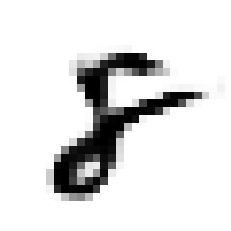

In [35]:
plt.imshow(make_digit(digit=8), cmap='gray_r', interpolation='nearest')
plt.axis('off')

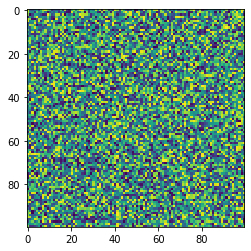

In [36]:
import numpy as np
data = np.zeros( (512,512,3), dtype=np.uint8)

from matplotlib import pyplot as plt
plt.imshow(noise, interpolation='nearest')
plt.show()